In [103]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [144]:
primary_date = datetime.date(2020, 7, 13)
if (datetime.date.today() > primary_date):
    print("It's already after the primary. Why are you running this?")
    
# import data
df = pd.read_excel("Roster.xlsx", index_col="Candidate")
df["Points Contributed"] = 0

In [145]:
# Calculate date range
start_date = datetime.date(2019, 6, 15)
day_delta = (datetime.date.today() - start_date).days
print("{0} days have elapsed since the start of the draft (June 15, 2019)".format(day_delta))

primary_delta = (primary_date - datetime.date.today()).days
print("{0} days until the start of the Democratic Convention (July 13, 2020)".format(primary_delta))


219 days have elapsed since the start of the draft (June 15, 2019)
175 days until the start of the Democratic Convention (July 13, 2020)


In [146]:
# Calculate point totals
# Total number of points on a per day basis for a candidate that has not dropped
ideal_points = np.array(range(day_delta))+1
drafter_points = {} # dictionary to hold point totals

for (candidate, drafter) in zip(df.index, df["Drafter"]):
    drop_date = df.at[candidate,"Date Dropped"]
    if(drop_date=="-"):
        drafter_points[drafter] = drafter_points.get(drafter, np.zeros(day_delta)) + ideal_points
        df.at[candidate,"Points Contributed"] = day_delta
    else:
        time_in_race = (drop_date.date() - start_date).days
        df.at[candidate,"Points Contributed"] = time_in_race
        temp_points = ideal_points.copy()
        temp_points[-1:time_in_race-1:-1] = time_in_race
        drafter_points[drafter] = drafter_points.get(drafter, np.zeros(day_delta)) + temp_points

# Sort in total accumulated point order
drafter_points = {k: v for k, v in sorted(drafter_points.items(), key=lambda e: e[1][-1], reverse=True)}
for drafter in drafter_points:
    print("{0} has {1} points".format(drafter, int(drafter_points[drafter][-1])))

Daniel has 736 points
Michael has 682 points
Sara has 660 points
Kevin M has 534 points
Jeff has 507 points
Kevin K has 505 points


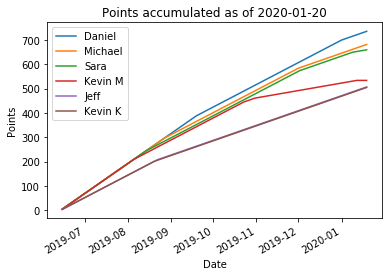

In [147]:
dates = [start_date + datetime.timedelta(days=i) for i in range(day_delta)]
hfig1 = plt.figure()
for drafter in drafter_points:
    plt.plot(dates, drafter_points[drafter]);

plt.gcf().autofmt_xdate();
plt.title("Points accumulated as of {}".format(datetime.date.today()));
plt.xlabel("Date");
plt.ylabel("Points");
plt.legend(drafter_points.keys());
plt.savefig("figs/point_total_{}.png".format(datetime.date.today()));
plt.savefig("figs/point_total.png");

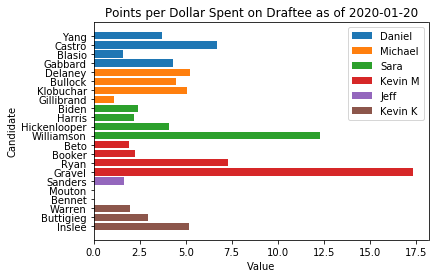

In [148]:
hfig2 = plt.figure()
df["Value"] = df["Points Contributed"] / df["Price Drafted"]
df = df.replace(np.inf, np.nan)
y_ticks = [];
sz = 0
for drafter in drafter_points:
    tmp = df[df.Drafter.eq(drafter)]
    plt.barh(range(sz,sz+tmp.shape[0]),tmp["Value"])
    sz += tmp.shape[0]
    for candidate in tmp.index.values:
        y_ticks.append(candidate)

plt.title("Points per Dollar Spent on Draftee as of {}".format(datetime.date.today()));
plt.xlabel("Value");
plt.ylabel("Candidate");
plt.yticks(range(df.shape[0]),y_ticks);
plt.legend(drafter_points.keys());
plt.gca().invert_yaxis();
